In [520]:
%matplotlib inline
import torch
#Import main library
from torch.utils.data import DataLoader
#Main class for threaded data loading
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
import timeit

start = timeit.default_timer()
#Optimizaiton config
target_class = 3
#Train a classifier for this class
batch_size = 1000
#Number of samples used to estimate the gradient (bigger = stable  training &  bigger learning rate)
learning_rate = 0.1
#Optimizer learning rate
epochs = 100
#Number of iterations over the whole dataset.
# Prepare data
train_data = np.load('../competition/train.npy')
val_data = np.load('../competition/val.npy')
def select_class(data, clss):
    images = np.array(data.item()["images"])
    labels = np.array(data.item()["labels"])
    labels = (labels == target_class).astype(int)
    return  images,labels

train_images,train_labels = select_class(train_data,target_class)
val_images, val_labels = select_class(val_data, target_class)
train_size = train_labels.shape[0]
val_size = val_labels.shape[0]
#Normalitzem les dades, pasem de RGB a un valor entre 0 i 1
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
val_images /= 255
train_images /= 255
print(train_size,"training images.")

47995 training images.


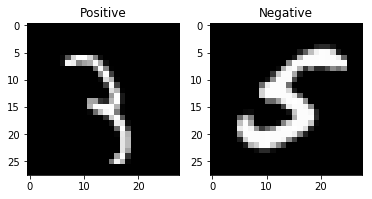

In [521]:
indices = np.arange(train_size)
positive_indices = indices[train_labels == 1]
negative_indices = indices[train_labels == 0]
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive")
plt.imshow(train_images[positive_indices[0], :, :], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Negative")
plt.imshow(train_images[negative_indices[0], :, :], cmap="gray")

In [522]:
#init weights
def init_weights(m):
    if type(m) == torch.nn.Linear:
        m.weight.data.fill_(0.01)

In [523]:
def weights_init_random(m):
    if type(m) == torch.nn.Linear:
        m.weight.data.normal_(0.01, 1)

In [524]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #Necessary for torch to detect this class as trainable
        #Here define network architecture
        self.layer1 = torch.nn.Linear(28**2, 8)
        #Linear layer with 32 neurons
        self.layer2 = torch.nn.Linear(8, 8)        
        #Linear layer with 64 neurons
        self.output = torch.nn.Linear(8, 1)
    def forward(self, x):
        #Here define architecture behavior
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))        
        return  torch.sigmoid(self.output(x))

In [525]:
#Binary output
#Instantiate network
model = NeuralNet()
#model.apply(weights_init_random)
#model.apply(init_weights)
torch.nn.init.xavier_uniform_(model.layer1.weight)
torch.nn.init.xavier_uniform_(model.layer2.weight)
torch.nn.init.xavier_uniform_(model.output.weight)
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0244, -0.0627, -0.0134,  ...,  0.0812,  0.0726,  0.0112],
                      [ 0.0114, -0.0015,  0.0804,  ..., -0.0213, -0.0333, -0.0284],
                      [-0.0174, -0.0453, -0.0085,  ..., -0.0646, -0.0224,  0.0852],
                      ...,
                      [ 0.0177,  0.0537,  0.0215,  ...,  0.0429, -0.0342,  0.0539],
                      [-0.0484, -0.0353, -0.0340,  ..., -0.0324,  0.0299, -0.0822],
                      [-0.0746, -0.0542, -0.0730,  ..., -0.0363, -0.0329,  0.0119]])),
             ('layer1.bias',
              tensor([-0.0164, -0.0044, -0.0082, -0.0338,  0.0216, -0.0217, -0.0046, -0.0033])),
             ('layer2.weight',
              tensor([[-0.0334,  0.5276, -0.1019,  0.4800,  0.2259, -0.1484, -0.0252,  0.1893],
                      [-0.3188,  0.3395, -0.6083,  0.5621, -0.5041, -0.3630, -0.0937,  0.3789],
                      [ 0.0297, -0.3770,  0.1778, -0.0884,  0.6089,  0.5823,  0.6114, 

In [526]:
#Create optimizer for the network parameters
optimizer = torch.optim.SGD(model.parameters(), learning_rate)
#Instantiate loss function
criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#Binary logistic regression
#Function to iterate the training set and update network weights with batches of images.
def train(model, optimizer, criterion):
    model.train()
    #training mode
    running_loss = 0
    running_corrects = 0
    total = 0
    for idx in range(0,train_size,batch_size):
        optimizer.zero_grad()
        #make the gradients 0
        x = torch.from_numpy(train_images[idx:(idx + batch_size), ...]).float()
        y = torch.from_numpy(train_labels[idx:(idx + batch_size), ...]).float()
        output = model(x.view(-1, 28 ** 2)) #forward pass
        preds = (output > 0.5).float()
        loss = criterion(output.view_as(y), y) #calculate the loss value
        loss.backward() #compute the gradients
        optimizer.step() #uptade network parameters
        #statistics
        running_loss += loss.item() * x.size(0)
        #print(preds.data.view(-1))
        running_corrects += torch.sum(preds.data.view(-1) == y.data.view(-1)).item() #.item() converts type from torch to python float or int
        total += float(y.size(0))
        
    epoch_loss = running_loss / total #mean epoch loss
    epoch_acc = running_corrects / total
    #mean epoch accuracy
    return epoch_loss, epoch_acc

In [527]:
# Function to iterate the validation set and update network weights with batches of images.
def val(model, criterion):
    model.eval()
    #validation mode
    running_loss = 0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        #We are not backpropagating trhough the validation set, so we can save speed
        for idx in range(0, val_size, batch_size):
            x = torch.from_numpy(val_images[idx:(idx + batch_size), ...]).float()
            y = torch.from_numpy(val_labels[idx:(idx + batch_size), ...]).float()
            output = model(x.view(-1, 28 ** 2))
            #forward pass
            preds = (output > 0.5).float()
            loss = criterion(output.view_as(y), y)
            #calculate the loss value
            #statistics
            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds.data.view(-1) == y.data.view(-1)).item()
            #.item() converts type from torch to python float or int
            total += float(y.size(0))
    epoch_loss = running_loss / total
    #mean epoch loss
    epoch_acc = running_corrects / total
    #mean epoch accuracy
    return epoch_loss, epoch_acc

train loss
0.04071304402276773
train accuracy
0.9877278883217002
val loss
0.2200841555131486
val accuracy
0.9184506455643482
Time:  48.110872011995525


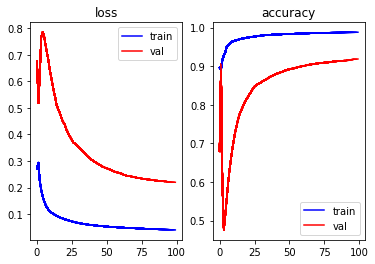

In [528]:
#Main training loop
train_loss =[]
train_accuracy = []
val_loss = []
val_accuracy = []
#Remove this line out of jupyter notebooks
from IPython import display
for epoch in range(epochs):
    t_loss, t_acc = train(model, optimizer, criterion)
    v_loss, v_acc = val(model, criterion)
    train_loss.append(t_loss)
    train_accuracy.append(t_acc)
    val_loss.append(v_loss)
    val_accuracy.append(v_acc)
    plt.subplot(1,2,1)
    plt.title("loss")
    plt.plot(train_loss,'b-')
    plt.plot(val_loss,'r-')
    plt.legend(["train","val"])
    plt.subplot(1,2,2)
    plt.title("accuracy")
    plt.plot(train_accuracy,'b-')
    plt.plot(val_accuracy,'r-')
    plt.legend(["train", "val"])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output(wait=True)
print("train loss")
print(t_loss)
print("train accuracy")
print(t_acc)
print("val loss")
print(v_loss)
print("val accuracy")
print(v_acc)
stop = timeit.default_timer()
print('Time: ', stop - start) 